# Jupiter

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy import interpolate
from scipy.interpolate import interp1d
import seaborn as sns

### Lambert Scaling Function

In [2]:
# To convert to phase angle= 0 use the lambertian phase integral (PSG eqn 77) to simulate full disk view
def get_scale_factor_lambert(phase_angle): # phase angle in degrees
    scale_val= (1/np.pi)*(np.sin(np.deg2rad(phase_angle))+(np.pi-np.deg2rad(phase_angle))*np.cos(np.deg2rad(phase_angle)))
    return scale_val

### Read in all data sources

In [4]:
# karkoschka 1998 full disk albedo (updated values)
kark_98= np.genfromtxt('1995_karkoschka.txt')
# Clarke et al. 1982 geo. albedo values- IUE
clarke_iue= pd.read_csv('clarke1982jupiter.csv')
# Giles et al. 2021 Juno Ultraviolet Spectrograph
giles= pd.read_csv('giles_figure1.csv')
# Li et al. 2018 Cassini Data supp. fig 7
cassini_li= pd.read_csv('Cassini_Liming_Li_SuppFig7.csv')
# Li et al. 2018 Monochromatic Geo. Albedo, fig 3a
fig3_li= pd.read_csv('jupiter_limingfig3.csv')
# Clark and Mccord 1979, localized Albedo data
cmc_center= pd.read_csv('clark&mccord_fig2_center.csv')
cmc_limb= pd.read_csv('clark&mccord_fig3_limb.csv')
# Mallama 2017 Johnson Cousins photometry
mallama_jc= np.genfromtxt('mallama2017_jupiter.txt')
# Betremieux et al. 2003 - HST I/F UV spectrum
uv_long= pd.read_csv('jupiter_uv_betremieux_fig5.csv')
# Roberge et al. 2017 SpeX Data (beyond 1.05 microns) (prior to this the source uses karkoshcka)
roberge= pd.read_csv('Roberge2017_geometricalbedo_allplanets.csv')

## Reading in Coulter, Barnes, Fortney 2022
- This comes directly from the publication but it needs reformatting
- the resultant arrays are saved to the directory

In [6]:
cbf_4= np.genfromtxt('coulterbarnesfortney_fig4_jup.txt')

In [25]:
phase_zero_wavelength=[]
phase_zero_albedo=[]

for row in cbf_4:
    if row[0]<2:
        phase_zero_wavelength.append(row[1])
        phase_zero_albedo.append(row[3])
   
cbf_2 = np.column_stack((phase_zero_wavelength, phase_zero_albedo))

### The monochromatic geometric albedo from Li et al. fig 3 needs to be sliced in the UV portion
- To get rid of the flat line at the beginning
- The final plot will also reduce a bit of the IR portion...
- This is only to reference the full data extent

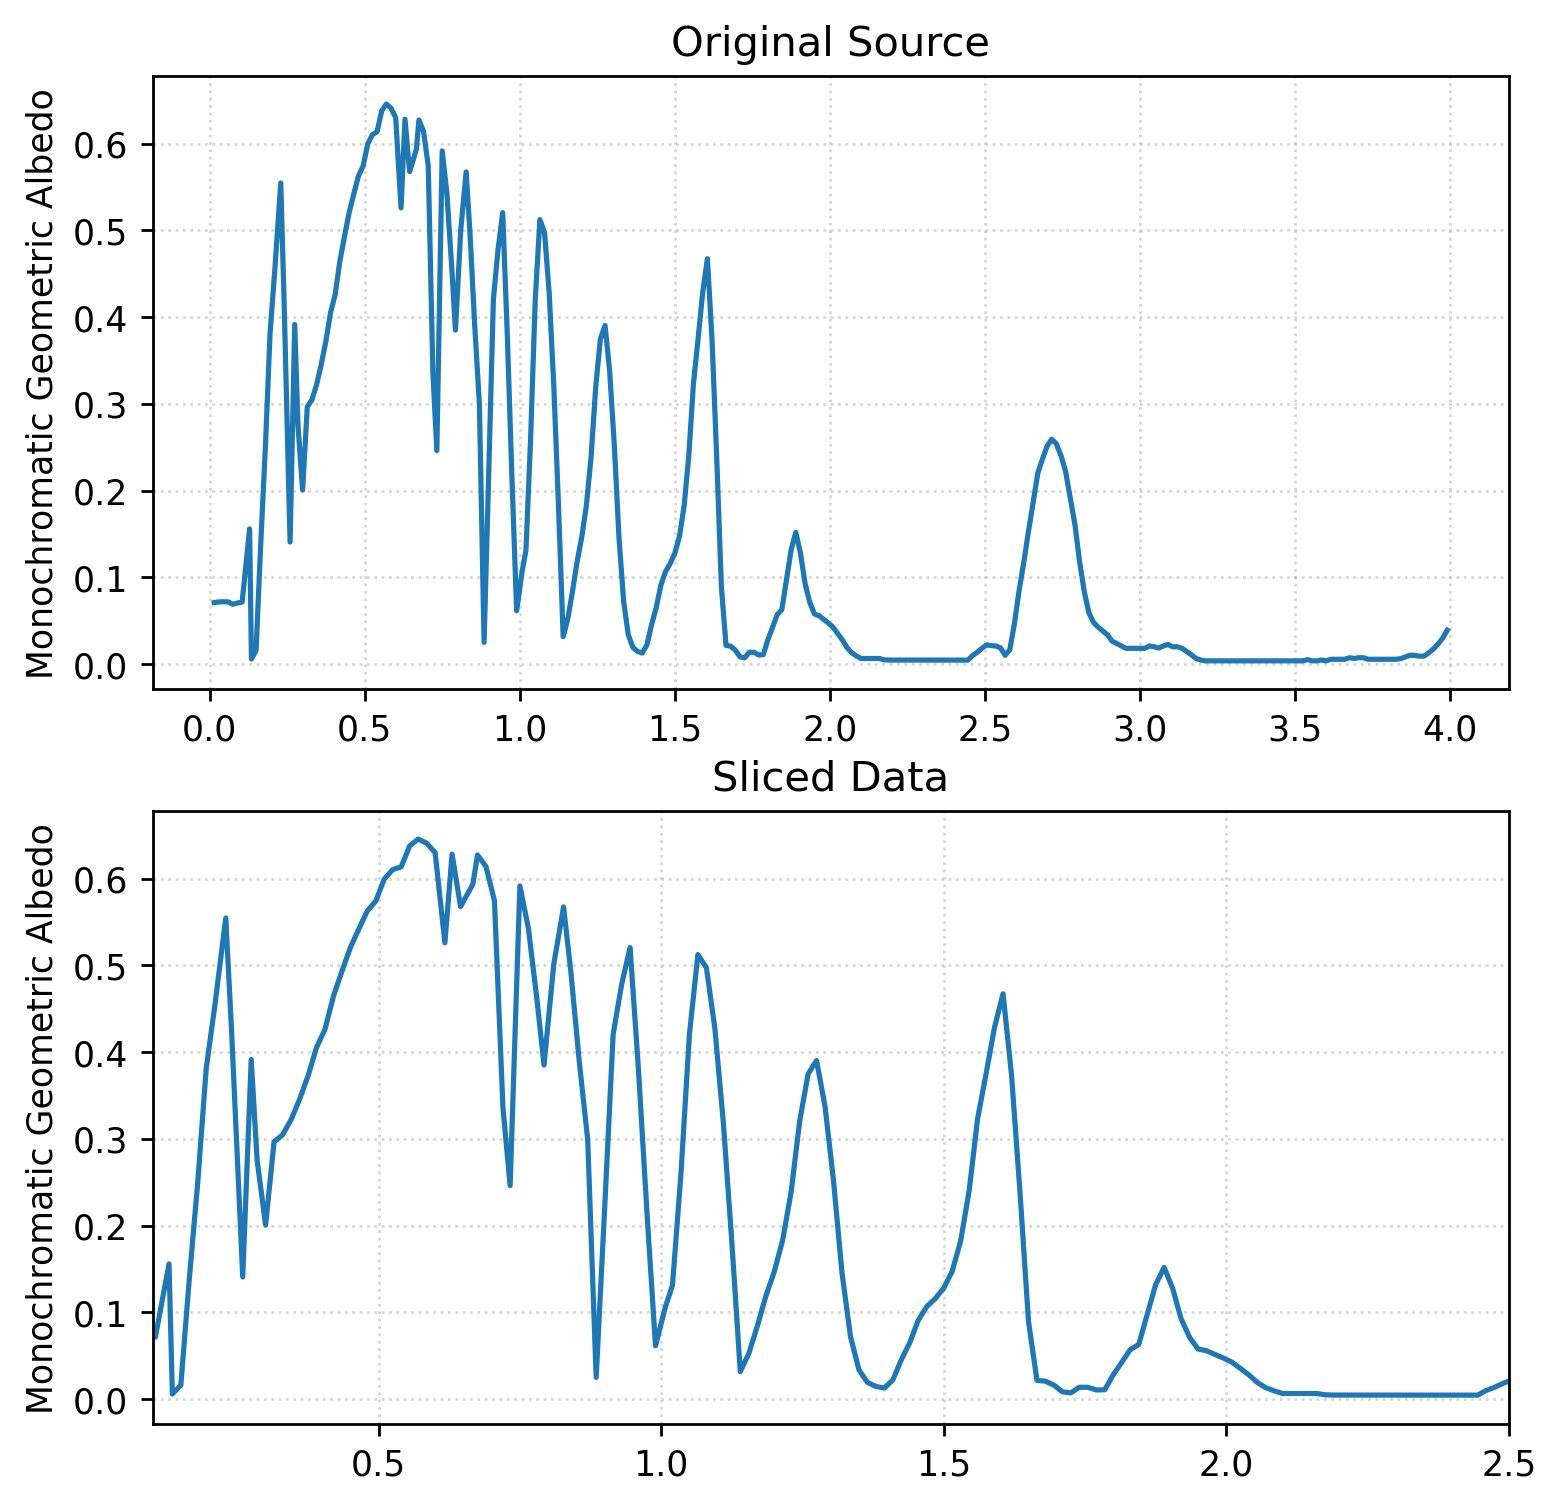

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), dpi=250)
axes[0].plot(fig3_li['x'], fig3_li['y'], label='L2018_f3')
axes[0].set_title('Original Source')
axes[0].grid(alpha=0.5, linestyle='dotted')
axes[0].set_ylabel('Monochromatic Geometric Albedo')

axes[1].plot(fig3_li['x'], fig3_li['y'], label='L2018_f3')
axes[1].set_title('Sliced Data')
axes[1].set_xlim(0.1,2.5)
axes[1].set_ylabel('Monochromatic Geometric Albedo')
axes[1].grid(alpha=0.5, linestyle='dotted')

## Slicing the Clark and McCord data sets
- below 0.74 microns the data seems inconsistent
- anomalous high values (possibly detector limitation) are eliminated by only including data beyond that value
- Karkoschka data is included in this example to compare the unusual variance

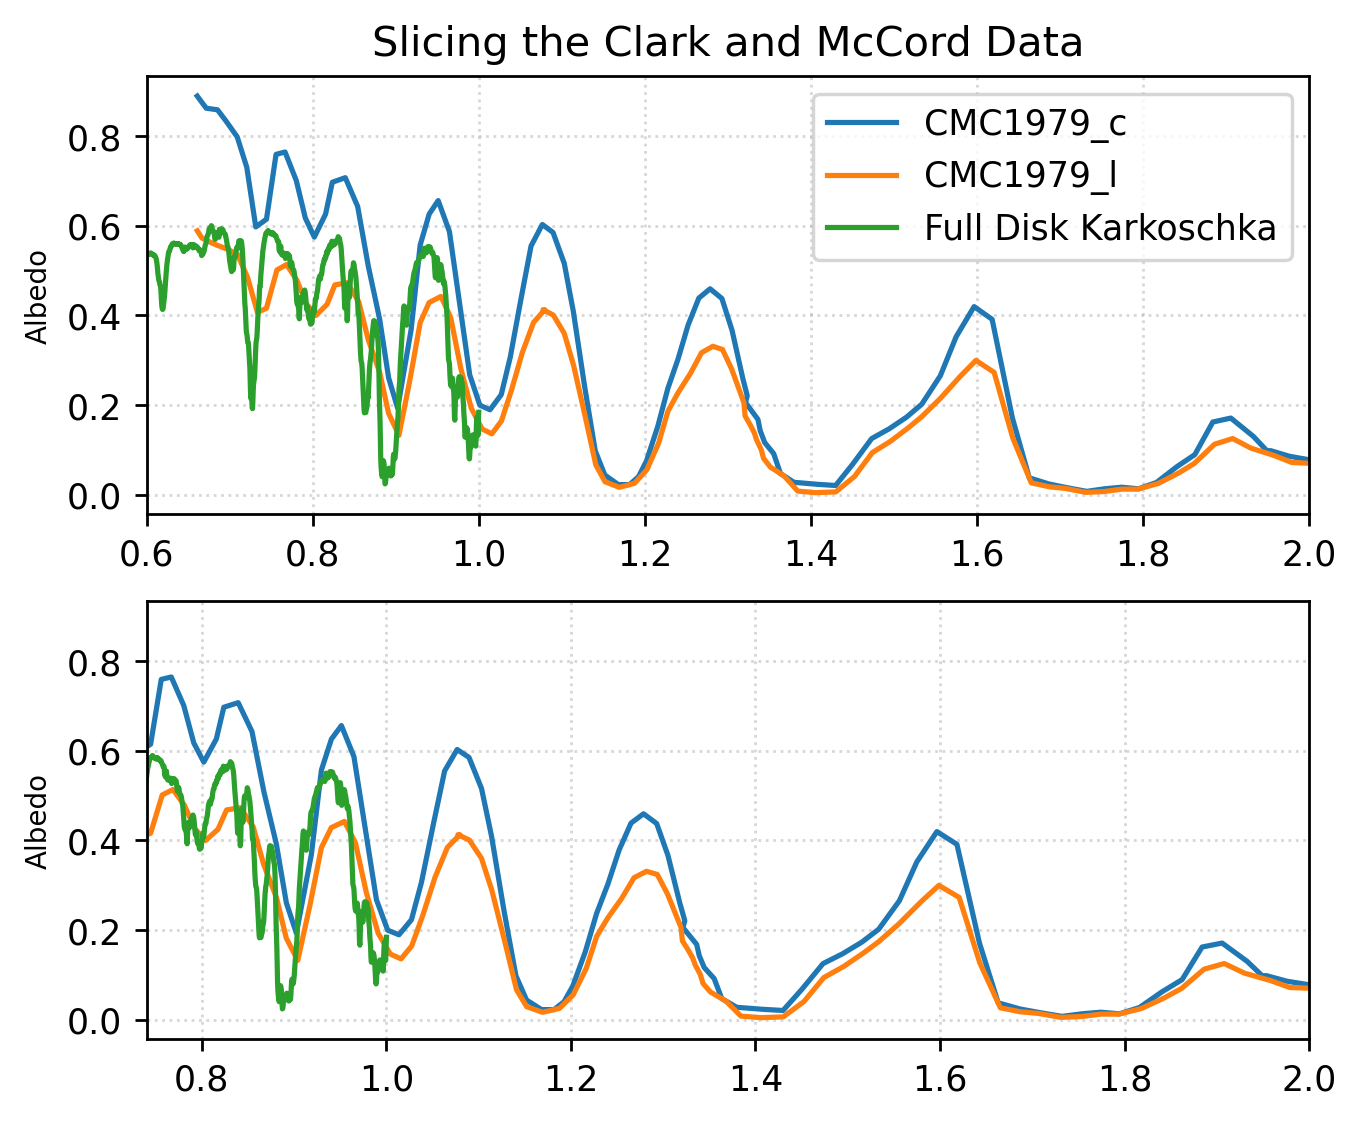

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), dpi=250)
axes[0].plot(cmc_center['x'],cmc_center['y'], label='CMC1979_c')
axes[0].plot(cmc_limb['x'],cmc_limb['y'], label='CMC1979_l')
axes[0].plot(kark[:,0]/1000, kark[:,4], label='Full Disk Karkoschka')
axes[0].grid(alpha=0.5, linestyle='dotted')
axes[0].set_ylabel('Albedo', fontsize=8)
axes[0].set_xlim(0.6,2)
axes[0].legend()
axes[0].set_title('Slicing the Clark and McCord Data')

axes[1].plot(cmc_center['x'],cmc_center['y'], label='CMC1979_c')
axes[1].plot(cmc_limb['x'],cmc_limb['y'], label='CMC1979_l')
axes[1].plot(kark[:,0]/1000, kark[:,4], label='Full Disk Karkoschka')
axes[1].set_xlim(0.74,2)
axes[1].set_ylabel('Albedo', fontsize=8)
axes[1].grid(alpha=0.5, linestyle='dotted')

In [10]:
def moving_average_smoothing(data, window_size):
    data = np.array(data)
    n = len(data)
    half_window = int(np.ceil(window_size * n / 2))
    smoothed_data = []
    for i in range(n):
        # Define the window range
        start = max(0, i - half_window)
        end = min(n, i + half_window + 1)
        
        # Compute the median of the window
        window = data[start:end]
        median_value = np.mean(window)
        # Append the median value to the smoothed data
        smoothed_data.append(median_value)
    return np.array(smoothed_data)

smooth_betrem= moving_average_smoothing(uv_long['y'], 0.04)
smooth_betrem_2= moving_average_smoothing(uv_long['y'], 0.06)

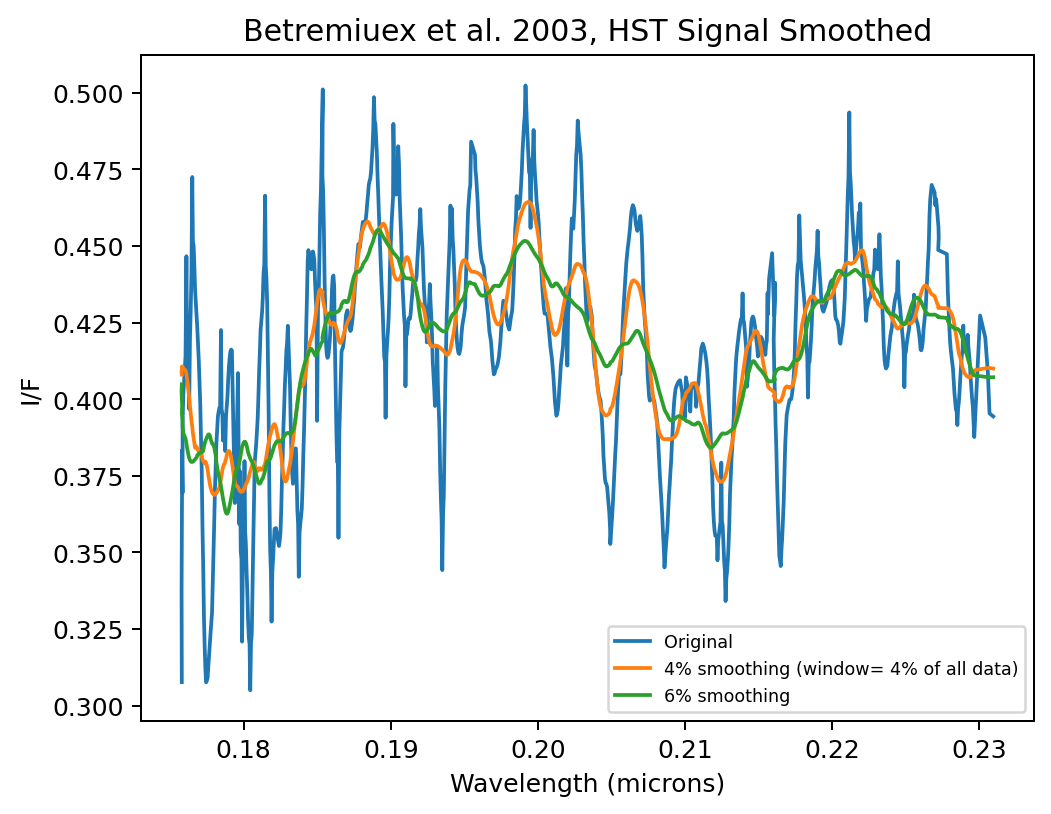

In [11]:
plt.figure(dpi=180)
plt.plot(uv_long['x'], uv_long['y'], label='Original')
plt.plot(uv_long['x'], smooth_betrem, label='4% smoothing (window= 4% of all data)')
plt.plot(uv_long['x'], smooth_betrem_2, label='6% smoothing')
plt.title('Betremiuex et al. 2003, HST Signal Smoothed')
plt.ylabel('I/F')
plt.legend(fontsize=7)
plt.xlabel('Wavelength (microns)');

# The Tri Plot

In [8]:
cb_palette= sns.color_palette("colorblind")

In [9]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

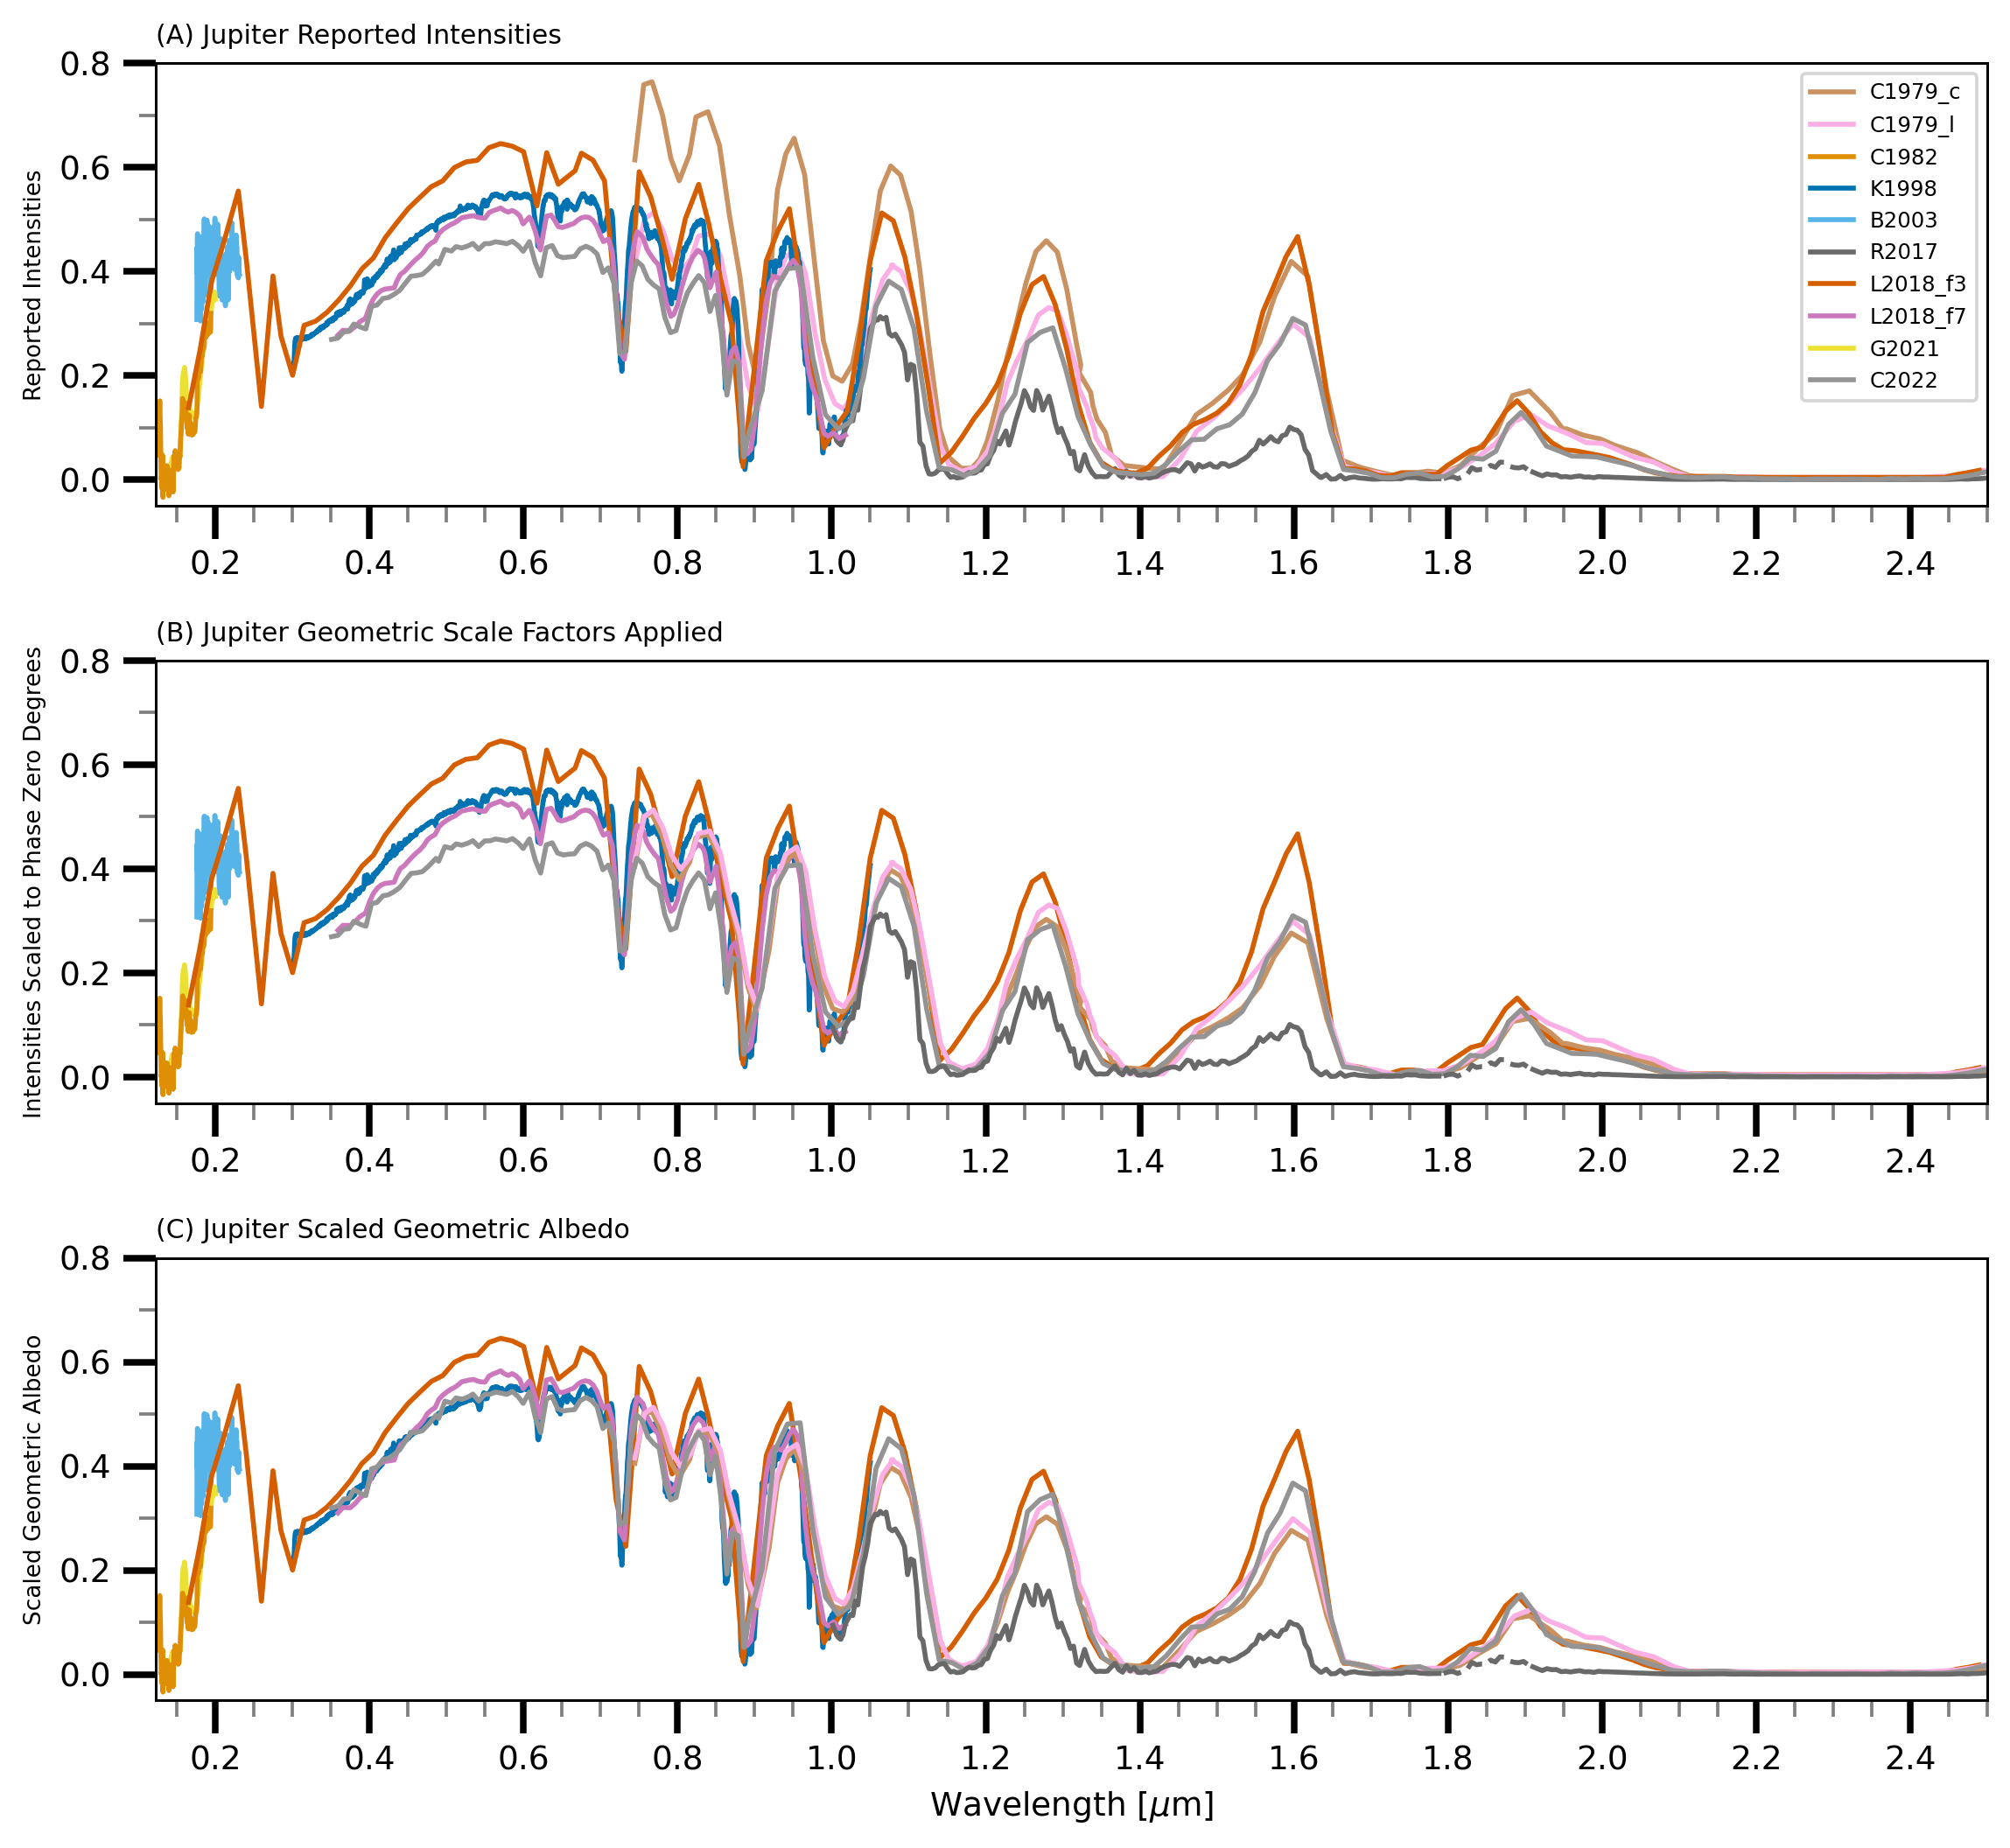

In [24]:
# Create figure and axes
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 9), dpi=270)
plt.subplots_adjust(hspace=0.35)

# DATA 
# FIGURE 1- ORIGINAL DATA
axes[0].plot(cmc_center[cmc_center['x']>0.74]['x'],cmc_center[cmc_center['x']>0.74]['y'], label='C1979_c', color=cb_palette[5])
axes[0].plot(cmc_limb[cmc_limb['x']>0.74]['x'],cmc_limb[cmc_limb['x']>0.74]['y'], label='C1979_l', color=cb_palette[6])
axes[0].plot(clarke_iue['x'], clarke_iue['y'], label='C1982',color=cb_palette[1])
axes[0].plot(kark_98[:,0]/1000,kark_98[:,3], label='K1998', color=cb_palette[0])
axes[0].plot(uv_long['x'], uv_long['y'], label='B2003', color=cb_palette[9],zorder=0)
axes[0].plot(roberge[(roberge['Wavelength [$\\mu$m]']>=1) & (roberge['Wavelength [$\\mu$m]']<=1.79)]['Wavelength [$\\mu$m]'], roberge[(roberge['Wavelength [$\\mu$m]']>=1) & (roberge['Wavelength [$\\mu$m]']<=1.79)]['Jupiter'], color='dimgrey', label='R2017')
axes[0].plot(roberge[(roberge['Wavelength [$\\mu$m]']>1.79) & (roberge['Wavelength [$\\mu$m]']<1.91)]['Wavelength [$\\mu$m]'], roberge[(roberge['Wavelength [$\\mu$m]']>1.79) & (roberge['Wavelength [$\\mu$m]']<1.91)]['Jupiter'], color='dimgrey',linestyle='--')
axes[0].plot(roberge[(roberge['Wavelength [$\\mu$m]']>=1.91)]['Wavelength [$\\mu$m]'], roberge[roberge['Wavelength [$\\mu$m]']>=1.91]['Jupiter'], color='dimgrey')
axes[0].plot(fig3_li[(fig3_li['x'] > 0.15) & (fig3_li['x'] < 2.5)]['x'], fig3_li[(fig3_li['x'] > 0.15) & (fig3_li['x'] < 2.5)]['y'], label='L2018_f3', color=cb_palette[3])
axes[0].plot(cassini_li['x'],cassini_li['y'], label='L2018_f7', color=cb_palette[4])
axes[0].plot(giles['x'], giles['y'], label='G2021', color=cb_palette[8], zorder=0)
axes[0].plot(cbf_2[:,0],cbf_2[:,1], label='C2022', color=cb_palette[7])

#axes[0].plot(uv_long['x'], smooth_betrem_2, label='B2003', color=cb_palette[9])

# # FIGURE 2- GEOMETRIC SCALING FACTORS APPLIED
axes[1].plot(kark_98[:,0]/1000,kark_98[:,3]/get_scale_factor_lambert(6.8), label='K1998', color=cb_palette[0])
axes[1].plot(uv_long['x'], uv_long['y'], label='B2003', color=cb_palette[9],zorder=0)
axes[1].plot(clarke_iue['x'], clarke_iue['y'], label='C1982',color=cb_palette[1])
axes[1].plot(giles['x'], giles['y'], label='G2021',color=cb_palette[8], zorder=0)
axes[1].plot(fig3_li[(fig3_li['x'] > 0.15) & (fig3_li['x'] < 2.5)]['x'], fig3_li[(fig3_li['x'] > 0.15) & (fig3_li['x'] < 2.5)]['y'], label='L2018_f3', color=cb_palette[3])
axes[1].plot(cassini_li['x'],cassini_li['y']/get_scale_factor_lambert(10.3), label='L2018_f7', color=cb_palette[4])
axes[1].plot(cmc_center[cmc_center['x']>0.74]['x'],cmc_center[cmc_center['x']>0.74]['y']*0.66, label='C1979_c', color=cb_palette[5])
axes[1].plot(cmc_limb[cmc_limb['x']>0.74]['x'],cmc_limb[cmc_limb['x']>0.74]['y'], label='C1979_l', color=cb_palette[6])
axes[1].plot(cbf_2[:,0],cbf_2[:,1]/get_scale_factor_lambert(1.7), label='C2022', color=cb_palette[7])
axes[1].plot(roberge[(roberge['Wavelength [$\\mu$m]']>=1) & (roberge['Wavelength [$\\mu$m]']<=1.79)]['Wavelength [$\\mu$m]'], roberge[(roberge['Wavelength [$\\mu$m]']>=1) & (roberge['Wavelength [$\\mu$m]']<=1.79)]['Jupiter'], color='dimgrey', label='R2017')
axes[1].plot(roberge[(roberge['Wavelength [$\\mu$m]']>1.79) & (roberge['Wavelength [$\\mu$m]']<1.91)]['Wavelength [$\\mu$m]'], roberge[(roberge['Wavelength [$\\mu$m]']>1.79) & (roberge['Wavelength [$\\mu$m]']<1.91)]['Jupiter'], color='dimgrey',linestyle='--')
axes[1].plot(roberge[(roberge['Wavelength [$\\mu$m]']>=1.91)]['Wavelength [$\\mu$m]'], roberge[roberge['Wavelength [$\\mu$m]']>=1.91]['Jupiter'], color='dimgrey')

# # FIGURE 3- EMPIRICAL SCALING FACTORS
axes[2].plot(kark_98[:,0]/1000,kark_98[:,3]/get_scale_factor_lambert(6.8), label='K1998', color=cb_palette[0])
axes[2].plot(uv_long['x'], uv_long['y'], label='B2003', color=cb_palette[9], zorder=0)
axes[2].plot(clarke_iue['x'], clarke_iue['y'], label='C1982', color=cb_palette[1])
axes[2].plot(giles['x'], giles['y'], label='G2021', color=cb_palette[8], zorder=0)
axes[2].plot(fig3_li[(fig3_li['x'] > 0.15) & (fig3_li['x'] < 2.5)]['x'], fig3_li[(fig3_li['x'] > 0.15) & (fig3_li['x'] < 2.5)]['y'], label='L2018_f3', color=cb_palette[3])
axes[2].plot(cassini_li['x'],(cassini_li['y']/get_scale_factor_lambert(10.3))*1.1, label='L2018_f7', color=cb_palette[4])
axes[2].plot(cmc_center[cmc_center['x']>0.74]['x'],cmc_center[cmc_center['x']>0.74]['y']*0.66, label='C1979_c', color=cb_palette[5])
axes[2].plot(cmc_limb[cmc_limb['x']>0.74]['x'],cmc_limb[cmc_limb['x']>0.74]['y'], label='C1979_l', color=cb_palette[6])
axes[2].plot(cbf_2[:,0],(cbf_2[:,1]/get_scale_factor_lambert(1.7))*1.186, label='C2022', color=cb_palette[7])
axes[2].set_xlim(0,2.5)
#axes[2].plot(composite_df['x_1'],composite_df['y_1'], linewidth=3, zorder=0, color='black')
axes[2].plot(roberge[(roberge['Wavelength [$\\mu$m]']>=1) & (roberge['Wavelength [$\\mu$m]']<=1.79)]['Wavelength [$\\mu$m]'], roberge[(roberge['Wavelength [$\\mu$m]']>=1) & (roberge['Wavelength [$\\mu$m]']<=1.79)]['Jupiter'], color='dimgrey', label='R2017')
axes[2].plot(roberge[(roberge['Wavelength [$\\mu$m]']>1.79) & (roberge['Wavelength [$\\mu$m]']<1.91)]['Wavelength [$\\mu$m]'], roberge[(roberge['Wavelength [$\\mu$m]']>1.79) & (roberge['Wavelength [$\\mu$m]']<1.91)]['Jupiter'], color='dimgrey',linestyle='--')
axes[2].plot(roberge[(roberge['Wavelength [$\\mu$m]']>=1.91)]['Wavelength [$\\mu$m]'], roberge[roberge['Wavelength [$\\mu$m]']>=1.91]['Jupiter'], color='dimgrey')


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~FORMAT~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for value in range(3):
    # Keeping the tick marks consistent across the plots
    axes[value].xaxis.set_major_locator(MultipleLocator(0.2))
    axes[value].xaxis.set_minor_locator(MultipleLocator(0.05))
    axes[value].yaxis.set_major_locator(MultipleLocator(0.2))
    axes[value].yaxis.set_minor_locator(MultipleLocator(0.1))
    # Customize the appearance of ticks
    axes[value].tick_params(axis='both', which='major', length=10, width=2, color='black')
    axes[value].tick_params(axis='both', which='minor', length=5, width=1, color='gray')
    axes[value].set_xlim(min(clarke_iue['x']),2.5)
    axes[value].set_ylim(-0.05,0.8)
    
axes[0].set_title('(A) Jupiter Reported Intensities', fontsize=8, loc='left')
axes[1].set_title('(B) Jupiter Geometric Scale Factors Applied', fontsize=8, loc='left')
axes[2].set_title('(C) Jupiter Scaled Geometric Albedo', fontsize=8, loc='left')
axes[0].set_ylabel('Reported Intensities', fontsize=7)
axes[1].set_ylabel('Intensities Scaled to Phase Zero Degrees', fontsize=7)
axes[2].set_ylabel('Scaled Geometric Albedo', fontsize=7)
axes[2].set_xlabel('Wavelength [$\mu$m]')
axes[0].legend(fontsize=6.5, loc='upper right')
bbox_to_anchor=(1.55,1)
#axes[0].set_title('Jupiter');
plt.savefig('final_plots/Jupiter_triplot.png', bbox_inches='tight');

# Consider smoothed data for other sources
- this was going to be considered for final plots
- but in order to maintain resolution of original sources this is only used for reference in this notebook

### Function Used for Smoothing

In [23]:
import numpy as np
from scipy.interpolate import interp1d

# Interpolation function
def interpolate_data(x, y, new_num_points):
    interpolator = interp1d(x, y, kind='slinear')  # You can also use 'cubic' or other methods
    x_new = np.linspace(min(x), max(x), new_num_points)
    y_new = interpolator(x_new)
    return x_new, y_new

# Existing moving average smoothing function
def moving_average_smoothing(data, window_size):
    data = np.array(data)
    n = len(data)
    half_window = int(np.ceil(window_size * n / 2))
    smoothed_data = []
    for i in range(n):
        # Define the window range
        start = max(0, i - half_window)
        end = min(n, i + half_window + 1)
        
        # Compute the mean of the window
        window = data[start:end]
        mean_value = np.mean(window)
        # Append the mean value to the smoothed data
        smoothed_data.append(mean_value)
    return np.array(smoothed_data)

# Example usage with your existing data
# Assuming uv_long['x'] and uv_long['y'] are the original data points

# Interpolate data (example: 2x resolution)
x_inter_li, y_interp_li = interpolate_data(fig3_li[(fig3_li['x'] > 0.17) & (fig3_li['x'] < 0.31)]['x'], fig3_li[(fig3_li['x'] > 0.17) & (fig3_li['x'] < 0.31)]['y']*0.87, new_num_points=4*len(fig3_li['x']))

# Apply smoothing to the interpolated data
smooth_interpolated_li1 = moving_average_smoothing(y_interp_li, 0.04)
smooth_interpolated_li2 = moving_average_smoothing(y_interp_li, 0.1)

## Compiling everything into a continuum...

In [20]:
x_1= list(clarke_iue[clarke_iue['x']<0.183]['x'])
y_1= list(clarke_iue[clarke_iue['x']<0.183]['y'])
x_2= fig3_li[(fig3_li['x']>0.175) & (fig3_li['x']<(kark_98[:,0]/1000).min())]['x']
y_2= fig3_li[(fig3_li['x']>0.175) & (fig3_li['x']<(kark_98[:,0]/1000).min())]['y']
x_3= kark_98[(kark_98[:,0]/1000)<1.037][:,0]/1000
y_3= kark_98[(kark_98[:,0]/1000)<1.037][:,3]
x_4= cbf_2[cbf_2[:,0]>1.03][:,0]
y_4= (cbf_2[cbf_2[:,0]>1.03][:,1]/get_scale_factor_lambert(1.7))*1.186
x_new= np.concatenate((x_1, x_2, x_3,x_4))
y_new= np.concatenate((y_1, y_2, y_3,y_4))
composite_df= pd.DataFrame({'x_1': np.round(x_new,4), 'y_1': np.round(y_new,4)})
composite_df2= composite_df[composite_df['x_1']<=2.5]

In [21]:
x_values= (0.1828, 0.18)
y_values= (0.237526, 0.250178)
dashed_line= np.column_stack((x_values, y_values))
x_vals2= (1.0368, 1.041115)
y_vals2= (0.2235,0.23137)
dashed_line2= np.column_stack((x_vals2,y_vals2))

# Save Composite Data
- Saving as csv and txt file

In [36]:
composite_df.to_csv('composite_spectrum/jupiter_composite_data.csv', index=False)
composite_df.to_csv('composite_spectrum/jupiter_composite_data.txt', sep=' ', index=False)

# Composite Spectrum 
- (not used in the paper, but shown for reference here)

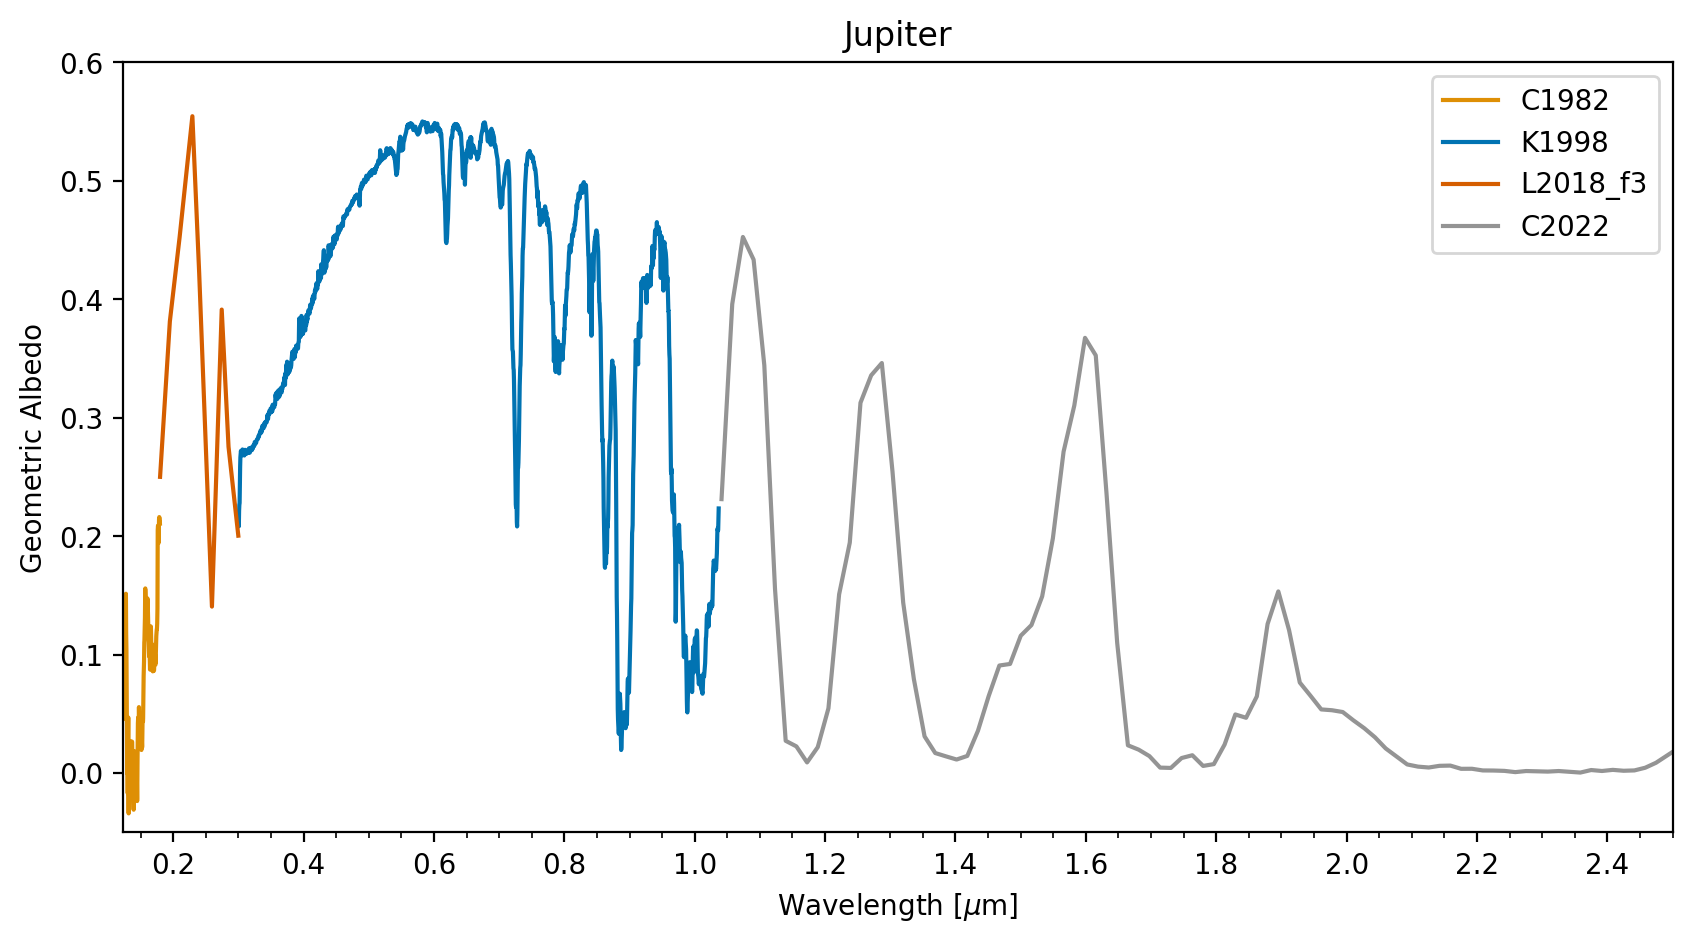

In [37]:
plt.figure(figsize=(10,5), dpi=200)
plt.plot(clarke_iue[clarke_iue['x']<0.18]['x'],clarke_iue[clarke_iue['x']<0.18]['y'], label='C1982', color=cb_palette[1])
plt.plot(kark_98[(kark_98[:,0]/1000)<1.037][:,0]/1000,kark_98[(kark_98[:,0]/1000)<1.037][:,3], label='K1998', color=cb_palette[0])
plt.plot(fig3_li[(fig3_li['x']>0.175) & (fig3_li['x']<(kark_98[:,0]/1000).min())]['x'],fig3_li[(fig3_li['x']>0.175) & (fig3_li['x']<(kark_98[:,0]/1000).min())]['y'], label='L2018_f3', color=cb_palette[3])
plt.plot(cbf_2[cbf_2[:,0]>1.03][:,0],(cbf_2[cbf_2[:,0]>1.03][:,1]/get_scale_factor_lambert(1.7))*1.186, label='C2022', color=cb_palette[7])

plt.gca().xaxis.set_major_locator(MultipleLocator(0.2))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.05))
plt.legend()
plt.xlim(clarke_iue['x'].min(),2.5)
plt.ylim(-0.05,0.6)
plt.xlabel('Wavelength [$\mu$m]')
plt.ylabel('Geometric Albedo')
plt.title('Jupiter')
plt.savefig('final_plots/jupiter_composite.png', bbox_inches="tight");